In [1]:
from polyase import *
import os
import numpy as np

#Define BASEDIR
#BASEDIR = '/Users/nadjanolte/NIB/ploidex_test'
#os.chdir(BASEDIR)
###pip install igv_notebook and python notebook

## Sample info

- 10 samples of Potato cv Atlantic
- Two conditions (tubers, leaves)
- tetraploid --> 4 haplotypes
var_obs_file
    Gene metadata
gene_counts
    Allele-specific counts for genes in each haplotype and by sample

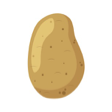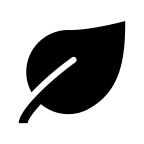

## How did we generate the allele-specific counts?

1) Extract transcripts from phased assembly.

We mapped the reads to the CDS regions only, because we noticed that UTRs have very variable length between the same gene on different haplotypes, which is most likely a annotation problem. So to avoid bias because of this we remove the UTRs. Also we only took the longest isoform for each gene as there are many isoforms that have a bad annotation.

Phased transcripts from potato assembly           |  UTR length problem
:-------------------------:|:-------------------------:
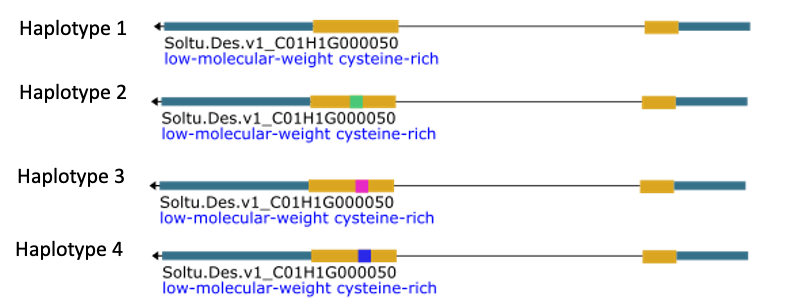 | 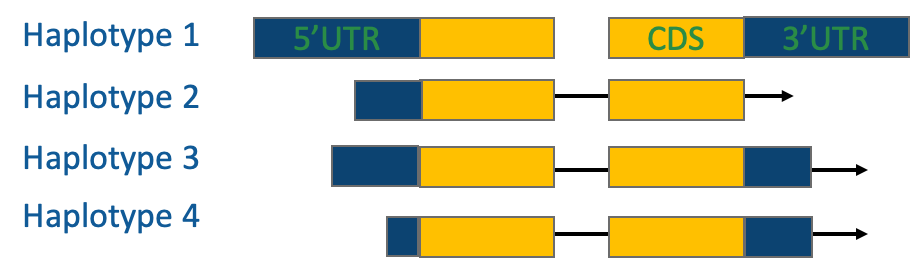


2) Map with minimap2 to transcripts
We count reads mapping best to one allele and multimapping counts (e.g if there is no differnce between alleles/genes)

Lets take a look at the input files:
* read counts for one sample

In [2]:
!head "{BASEDIR}/03_GENECOUNTS/SRR14993892_leaf.counts.tsv"

head: cannot open '{BASEDIR}/03_GENECOUNTS/SRR14993892_leaf.counts.tsv' for reading: No such file or directory


For each transcript_id we have the number of unique counts and the number of ambigious counts (when a read maps equally well to one or more transcript_ids)

## 1) Loading the allele-specific count data 

First we load in the allele-specific counts for our 10 samples (IsoSeq from 5 x potato tubers, 5 x potato leaves). We also have some metadata ("metadata.tsv") that links the gene ids from the alleles of a gene together with "Synt_ids" and we have some information about the allele lengths that we use for quality control.

In [3]:
# Metadata for genes
var_obs_file = "/scratch/nadjafn/potato-allelic-orthogroups/output_atlantic/07_SYNTELOG_SIMILARITY/ATL_v3.hc_gene_models.repr_blast_syntelog_blast_analysis.tsv"
# directory of gene counts from minimap2
gene_counts_dir = "/scratch/nadjafn/Atlantic_ASE/polyploid-allele-exp/results/03_GENECOUNTS"
# Define sample IDs and their conditions
sample_info = {
    "SRR14993892": "leaf",
    "SRR14993893": "leaf", 
    "SRR14993894": "leaf",
    "SRR14993895": "leaf",
    "SRR14996168": "leaf",
    "SRR14995031": "tuber",
    "SRR14995032": "tuber",
    "SRR14995033": "tuber",
    "SRR14995034": "tuber",
    "SRR14995933": "tuber",
}

# Load the data into an AnnData object
allelic_data = load_ase_data(
    var_obs_file=var_obs_file,
    gene_counts_dir=gene_counts_dir,
    sample_info=sample_info, fillna=0)

### Task 1: look at the metadata information of each transcript id

In [4]:
allelic_data.var.sort_values("CDS_haplotype_with_longest_annotation").head()

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch
transcript_id,,,,,,
Soltu.Atl_v3.01_2G036600.1,Synt_id_6024,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN
Soltu.Atl_v3.03_2G019770.2,Synt_id_11555,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN
Soltu.Atl_v3.12_1G001120.1,Synt_id_29895,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN
Soltu.Atl_v3.02_1G006530.9,Synt_id_6894,1hap1_1hap2_1hap3_1hap4_s,1G,more_5%_difference,NaN,NaN
Soltu.Atl_v3.01_1G031240.1,Synt_id_6046,1hap1_1hap2_1hap3_1hap4_s,1G,more_5%_difference,NaN,NaN


What do the columns mean?
* transcript_id:
* Gene_id: This is an identifier for each gene, transcript_id that belong to the same gene (these are 'allels') have the same Synt_id
* synteny_category: This tells us for each gene on which haplotype it is present: e.g 2hap1_2hap2_0hap3_1hap4_no_s == 2-times on haplotype 1, 2-times on halotype 2, not on haplotype 3, the s/no_s means: syntenic/non_syntenic
* CDS_haplotype_with_longest_annotation: We compared the length of the gene on the different haplotypes and store the information which haplotype has the longest annotation e.g 4G == 4. haplotype or if they have the same length ("equal length").
* CDS_length_category: This tells us how different is the longest allele compared to the shortest allele (e.g less_1%_difference, more_5%_difference)

Example for synteny_category:
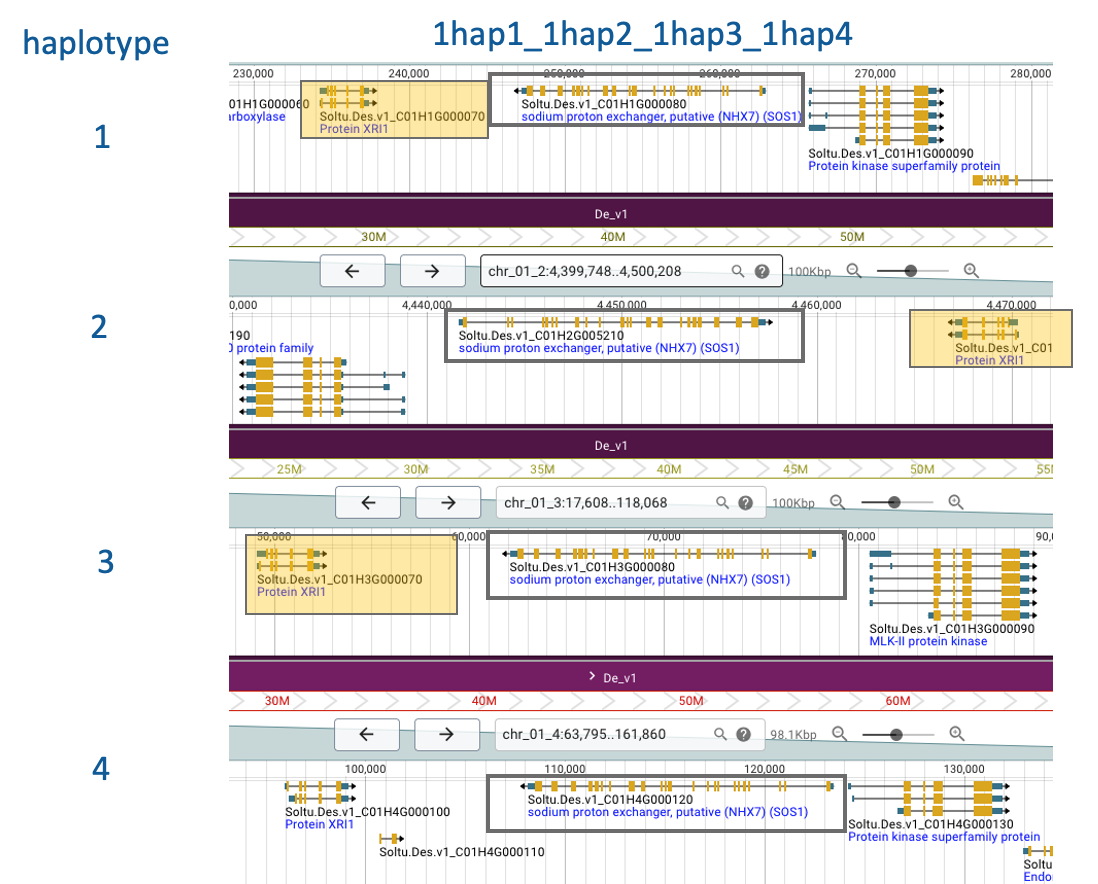

### Task 2: Look at the information of counts

In [5]:
allelic_data.layers['unique_counts']

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.]], shape=(10, 97433))

In [6]:
allelic_data.layers["ambiguous_counts"]

array([[  0.,   2.,  23., ...,   0.,   0.,   0.],
       [  0.,   1.,  11., ...,   0.,   0.,   0.],
       [  0.,   3., 113., ...,   0.,   0.,   0.],
       ...,
       [  0.,   3.,  19., ...,   0.,   0.,   0.],
       [  0.,   4.,  13., ...,   0.,   0.,   0.],
       [  0.,   2.,   7., ...,   0.,   1.,   0.]], shape=(10, 97433))

In [7]:
allelic_data.var_names

Index(['Soltu.Atl_v3.06_2G013790.1', 'Soltu.Atl_v3.01_2G036600.1',
       'Soltu.Atl_v3.09_0G013460.1', 'Soltu.Atl_v3.02_3G008660.1',
       'Soltu.Atl_v3.04_4G019190.2', 'Soltu.Atl_v3.05_2G007830.1',
       'Soltu.Atl_v3.05_3G008540.1', 'Soltu.Atl_v3.08_2G003100.1',
       'Soltu.Atl_v3.07_4G020650.1', 'Soltu.Atl_v3.01_4G025100.2',
       ...
       'Soltu.Atl_v3.01_4G008550.1', 'Soltu.Atl_v3.03_2G001580.2',
       'Soltu.Atl_v3.10_1G008360.1', 'Soltu.Atl_v3.08_2G008090.1',
       'Soltu.Atl_v3.07_3G020880.1', 'Soltu.Atl_v3.12_0G007550.1',
       'Soltu.Atl_v3.09_0G014070.1', 'Soltu.Atl_v3.S159640.1',
       'Soltu.Atl_v3.06_4G023260.2', 'Soltu.Atl_v3.02_1G024530.1'],
      dtype='object', name='transcript_id', length=97433)

In [8]:
allelic_data.obs

,condition
SRR14993892,leaf
SRR14993893,leaf
SRR14993894,leaf
SRR14993895,leaf
SRR14996168,leaf
SRR14995031,tuber
SRR14995032,tuber
SRR14995033,tuber
SRR14995034,tuber
SRR14995933,tuber


* rows: our 10 replicates
* columns: the transcript_ids


# 2) Quality Control
Now that we inspected the count data and metadata, we can start to do some quality control


## Criteria for quality control

- Low expressed genes
- High bias towards one allele
- Multimapping ratio
- Same CDS length

### A) Filter genenes with low expression

We filter Syntelog groups that 

In [ ]:
allelic_data = filter_low_expressed_genes(allelic_data,
                                          min_expression=20,
                                          group_col= 'Synt_id',
                                          mode= 'all', 
                                          ibrary_size_dependent= True)

# maybe normalize the data between different samples; filter based on lib size, maybe TPM

Using library-size adjusted thresholds:
  SRR14993892: 4.85
  SRR14993893: 2.55
  SRR14993894: 24.11
  SRR14993895: 11.95
  SRR14996168: 18.96
  ... and 5 more
Filtered out 0 groups
Kept 3413 / 3413 items


### B) High bias towards one allele
Calculate allelic ratios to see if there are genes that have high bias (e.g > 0.6 of total counts) towards one allele.

For that we will calculate the allelic ratios simply by: allelic_ratio = allele counts/total counts for this gene.
We will use these alleic ratios to make a histogram later.

In [10]:
allelic_data = calculate_allelic_ratios(allelic_data, 'unique_counts')


In [11]:
allelic_data.layers["allelic_ratio_unique_counts"]

### Rows are replicates; columns are transcript ids

array([[0.22929936, 0.03676471, 0.28947368, ..., 0.        , 0.        ,
        0.        ],
       [0.26708075, 0.01470588, 0.27536232, ..., 0.        , 0.        ,
        0.        ],
       [0.22911548, 0.03454545, 0.3088    , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.27802691, 0.044     , 0.29473684, ..., 0.        , 0.        ,
        0.        ],
       [0.29811321, 0.01290323, 0.3021978 , ..., 0.        , 0.        ,
        0.        ],
       [0.30417495, 0.0255102 , 0.27604167, ..., 0.00066401, 0.0075188 ,
        0.00740741]], shape=(10, 3413))

### C) Multimapping ratio
For each transcript_id we have the unique counts and the multimapping/ambigious counts, we use this to calculate the multimapping ratio for each gene/ Synt_id:


Mulitmapping ratio = number of ambiguous counts / number of total (unique + ambiguous counts)

#### Question: What does it mean to have a high multimapping ratio?

#### Answer

If two/or more alles are identical they will have all reads multimapping

In [12]:
# now lets calculate the multimapping ratios for each Synt_id
allelic_data = calculate_multi_ratios(allelic_data, 'unique_counts', 'ambiguous_counts')


In [13]:
# The multimapping information also has been added to the andata object
allelic_data.var.head()

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch,multimapping_ratio
transcript_id,,,,,,,
Soltu.Atl_v3.04_3G005900.1,Synt_id_1846,1hap1_1hap2_3hap3_1hap4_no_s,NaN,NaN,NaN,NaN,0.015955
Soltu.Atl_v3.06_2G012290.1,Synt_id_10191,1hap1_2hap2_1hap3_1hap4_no_s,NaN,NaN,NaN,NaN,0.555839
Soltu.Atl_v3.10_3G001680.1,Synt_id_26163,1hap1_1hap2_1hap3_1hap4_s,1G,more_10%_difference,NaN,NaN,0.270709
Soltu.Atl_v3.03_4G019300.1,Synt_id_11647,1hap1_1hap2_1hap3_2hap4_no_s,NaN,NaN,NaN,NaN,0.042925
Soltu.Atl_v3.01_3G029840.1,Synt_id_5731,1hap1_1hap2_1hap3_1hap4_s,2G,more_10%_difference,NaN,NaN,0.678792


#### QC Plot

Now we can make a histogram to show the distribution of allelic ratios for the genes with low mulitmapping ratios/ ambigious counts (GREEN) and high mulitmapping ratios/ ambigious counts (GREY)

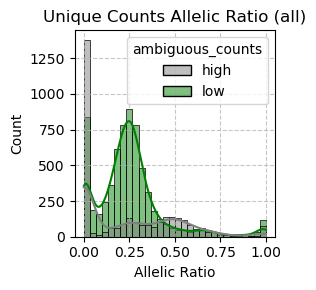

In [14]:
plot_allelic_ratios(
    allelic_data,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

### Difference between distributions?

- Can you explain why most alleles with low mulitmapping ratios have 0.25 allelic ratio 
- And what is the distribution for the genes with high mulitmapping ratios

## Answer

We observe that some genes have high bias towards one allele ('allelic_ratio_unique_counts' > 0.6). We can inspect these genes to see if there are any mistakes. In the next plot we will only look at genes that have the same CDS length for all allelels and low multimapping ratios, to ensure that these factors don't cause the observed bias.

In [15]:
high_bias = allelic_data[:,(allelic_data .var['multimapping_ratio'] < 0.25) & (allelic_data .layers['allelic_ratio_unique_counts'] > 0.6).all(axis=0) & (allelic_data .var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")]# & (test_ad.obsm["CDS_haplotype_with_longest_annotation"] == "equal_lengths") ]
high_bias.var.head()

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch,multimapping_ratio
transcript_id,,,,,,,
Soltu.Atl_v3.02_4G016630.1,Synt_id_8100,1hap1_1hap2_1hap3_1hap4_s,1G,more_10%_difference,NaN,NaN,0.012953
Soltu.Atl_v3.08_1G011030.1,Synt_id_22948,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.066812
Soltu.Atl_v3.07_3G020380.1,Synt_id_21422,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.006333
Soltu.Atl_v3.03_3G019960.1,Synt_id_10803,1hap1_1hap2_1hap3_1hap4_s,3G,more_20%_difference,NaN,NaN,0.249174
Soltu.Atl_v3.02_1G001420.1,Synt_id_6413,1hap1_1hap2_1hap3_1hap4_s,3G,more_20%_difference,NaN,NaN,0.034742


Now we want to look at one of these genes with high bias in more detail. First we look at the allelic ratios to see which of the alleles has the highest expression

In [16]:
import pandas as pd

# We will look at the allelic ratios
df = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].layers['allelic_ratio_unique_counts']
pd.DataFrame(data= df, index = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].obs.index, columns = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].var_names)

transcript_id,Soltu.Atl_v3.04_4G002730.2,Soltu.Atl_v3.04_2G002760.1,Soltu.Atl_v3.04_3G002920.1,Soltu.Atl_v3.04_1G003230.1
SRR14993892,0.089231,0.076923,0.126154,0.707692
SRR14993893,0.141304,0.070652,0.157609,0.630435
SRR14993894,0.081909,0.094873,0.117855,0.705362
SRR14993895,0.108108,0.076577,0.117117,0.698198
SRR14996168,0.079353,0.079353,0.090909,0.750385
SRR14995031,0.091613,0.080000,0.123871,0.704516
SRR14995032,0.065637,0.048263,0.121622,0.764479
SRR14995033,0.071429,0.061576,0.149015,0.717980
SRR14995034,0.134615,0.053419,0.209402,0.602564
SRR14995933,0.075571,0.056239,0.135325,0.732865


The rows are the replicates and the columns are the alleic ratios for alleles.

Which allele has the highest expression? (look at the 04_{haplotype}G of the gene id for the allele)

Lets also look at the metadata for this gene: 

In [17]:
allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].var

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch,multimapping_ratio
transcript_id,,,,,,,
Soltu.Atl_v3.04_4G002730.2,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548
Soltu.Atl_v3.04_2G002760.1,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548
Soltu.Atl_v3.04_3G002920.1,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548
Soltu.Atl_v3.04_1G003230.1,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548


Which of the alleles is the longest in the annotation? And which one with the highest allelic ratio? Do you see a connection?

Lets also look at the annotation in the [genome browser](https://spuddb.uga.edu/jb2/?session=share-Q7AqVFDKBg&password=OioEy).
Open the link and upload bigwig files provided [here]. You can upload them by clicking [Add a track] > [choose file]
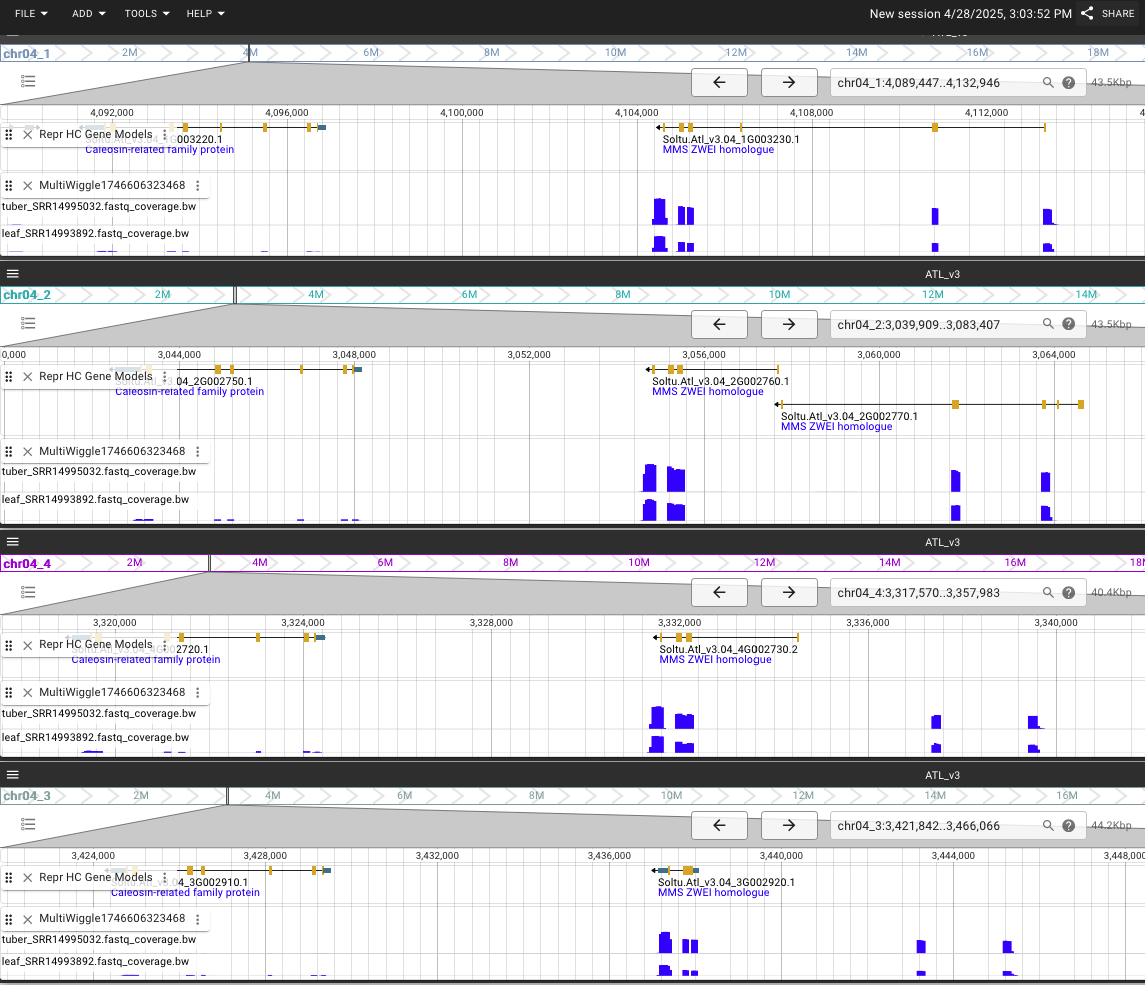

Do you think the gene annotation is correct on all haplotypes?

### Alleles with same CDS length

To avoid annotation errors to bias the results, we will only look at alleles that have the same length on all haplotypes:

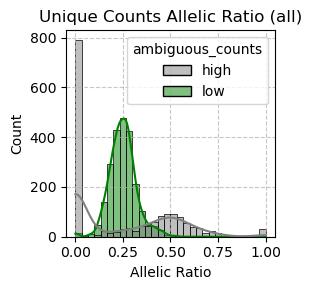

In [18]:
# filter transcripts that are not equal lengths
mask = allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths"
allelic_data_length_filter = allelic_data[:,mask].copy()
plot_allelic_ratios(
    allelic_data_length_filter,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

Without filtering:

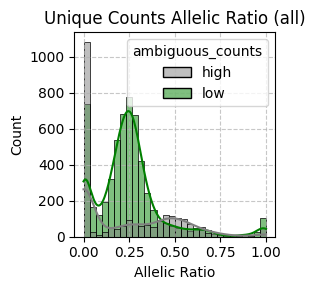

What is the difference between the length filtered results and the unfiltered ones? Do we will observe genes with high bias?

# 3) Testing for allelic imbalance

Now that we have the counts per allele and filtered genes that could be biased by high number of ambgious reads and length differences, we want to test if there are genens that have unbalanced allelic expression (> or < than 0.25).

For this we use the likelihood ratio test from [Isotools](https://isotools.readthedocs.io/en/latest/notebooks/09_diff_splice.html) to test if there is a signigicant difference between our observed allelic counts and 25% of the total counts.

Why do we only test one condition here? (not leaf and tuber at the same time)
Because between tissues we expect that there are also trans effects (different transcription factors), but within one condition only cis differences (promotors, ..) should be responsible for difference in expression. ![alt text](image.png)

Found 23 from 57 syntelogs with at least one significantly different allele (FDR < 0.005 and ratio difference > 0.05)


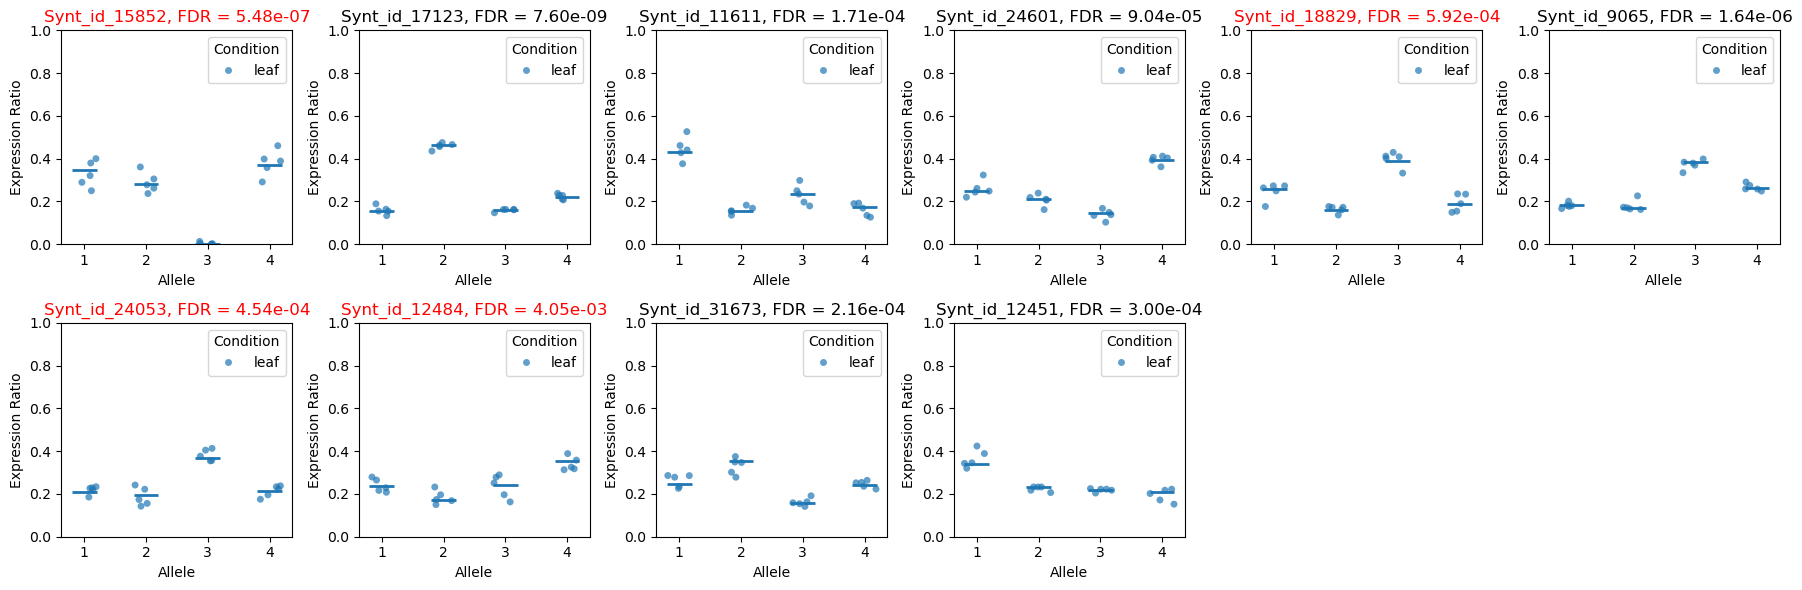

In [19]:
# select only the genes with equal lengths, low multimapping ratio and synteny category "1hap1_1hap2_1hap3_1hap4_s"
mask = (allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths" ) & (allelic_data.var["multimapping_ratio"] < 0.25) & (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
allelic_data_length_filter = allelic_data[:,mask].copy()

# Test for differential allelic ratios withing conditions
results = test_allelic_ratios_within_conditions(allelic_data_length_filter, layer="unique_counts", test_condition= "leaf", inplace=True)

# Plot the results
fig = plot_top_differential_syntelogs(results,n =10, figsize=(3*6, 2*3), sort_by='ratio_difference', sig_threshold=0.005, difference_threshold=0.05)

The Alleles with a red title have some signigicant change in the allelic ratio. Not all alleles have equal expression

Lets look at the gene with "Synt_id_17123" in more detail:

In [20]:
results[results["Synt_id"] == "Synt_id_17123"]

,Synt_id,allele,transcript_id,p_value,ratio_difference,n_alleles,ratios_leaf_mean,ratios_rep_leaf,FDR
71,Synt_id_17123,2,Soltu.Atl_v3.06_2G000620.2,3.332783e-11,0.212934,4,0.462873,"[0.4659248956884562, 0.4356955380577428, 0.456...",7.598745e-09
69,Synt_id_17123,3,Soltu.Atl_v3.06_3G000610.3,7.212484e-09,0.088604,4,0.161335,"[0.1627260083449235, 0.14698162729658792, 0.16...",5.481488e-07
70,Synt_id_17123,1,Soltu.Atl_v3.06_1G000450.1,8.571664e-08,0.093830,4,0.156109,"[0.13351877607788595, 0.1889763779527559, 0.15...",3.908679e-06
68,Synt_id_17123,4,Soltu.Atl_v3.06_4G000620.1,1.950837e-03,0.030176,4,0.219763,"[0.23783031988873435, 0.2283464566929134, 0.22...",8.392280e-03


The column "ratio_difference" is the difference between our mean allele ratio and the expected ratio (0.25)

Lets look at the expression for these alleles of one sample in the genome Browser https://spuddb.uga.edu/jb2/?session=share-y51Gk46x4-&password=RWDWO. Does it really look like that allele 2 has higher expression than the other alleles?

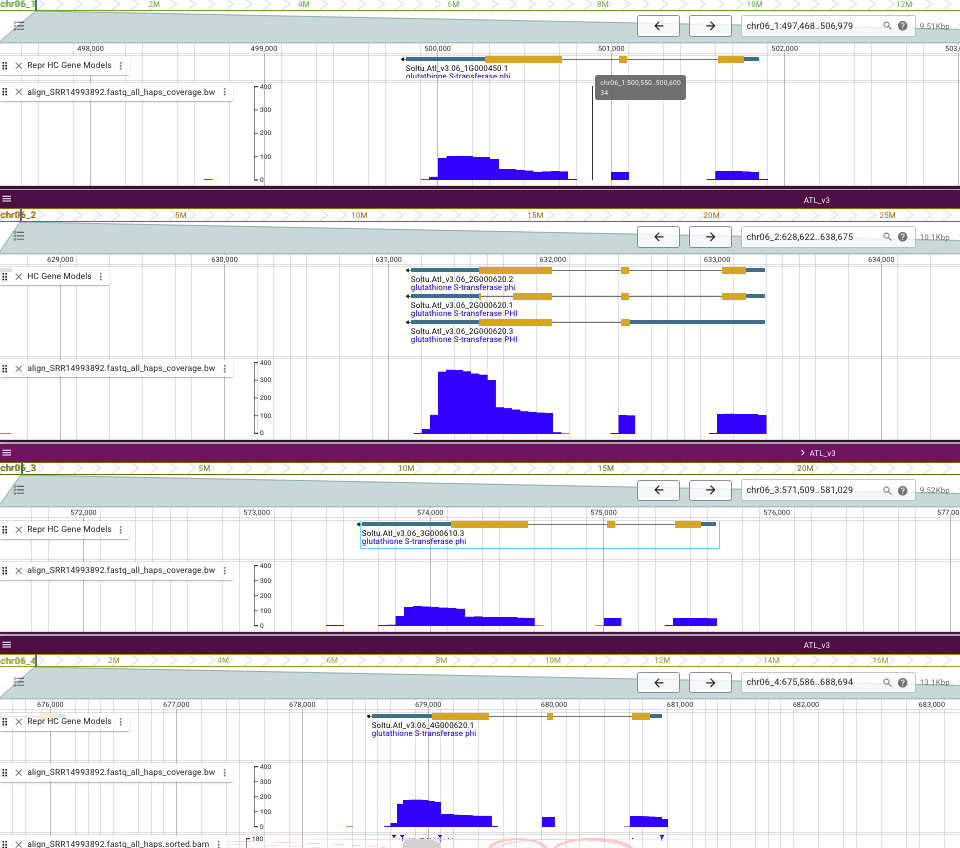

### Cis reulatory differences: Promotor analysis

Why is the allele 2 of gluthadione S-transferase higher expressed than the other alleles?

The differntial expression should be expalined by cis-regulatory differences between the allles, e.g:
* differences in methylation
* different transcription factor binging sites in the promotor


Since we can easily look at the promotors in our phased assembly, we check if there are any major differences.
We did a mulitple sequence alignment of the promotor regions (3000 bp upstream of start codon) with [DigAlign](
https://www.genome.jp/digalign/u/Nh0fqnx91m8IIspreJ9H6Q/aln/promoter_Soltu.Atl_v3.06_1G000/promoter_Soltu.Atl_v3.06_2G000/promoter_Soltu.Atl_v3.06_3G000/promoter_Soltu.Atl_v3.06_4G000).


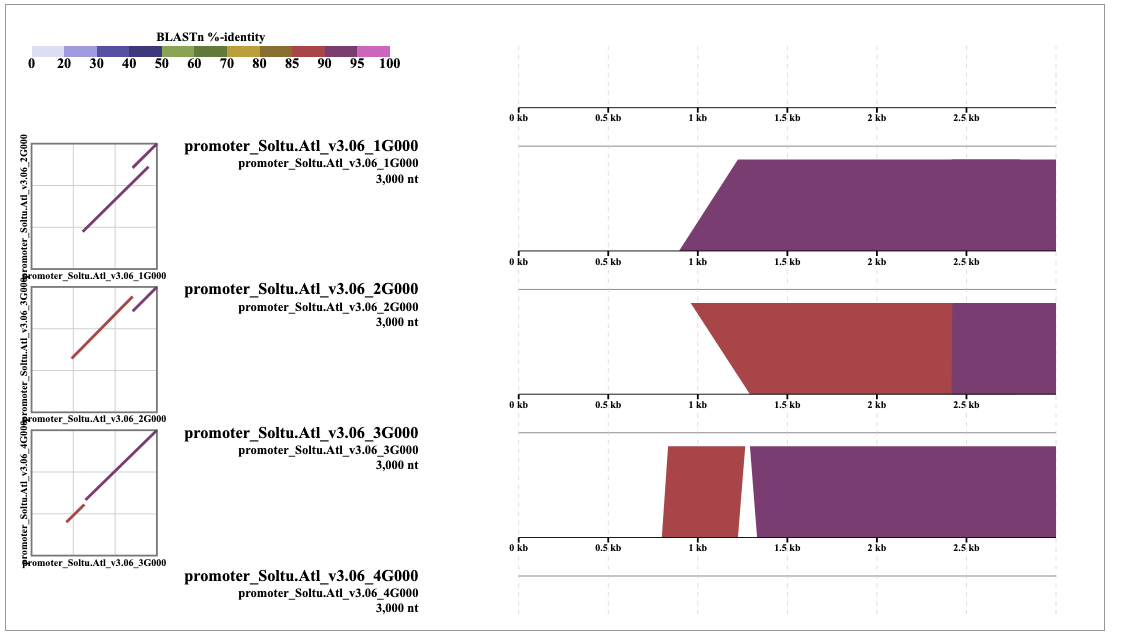

What do you notice is the difference between the promotor of allele 2 and the other promotors?



We look at the insertion of promotor of allele 2 in more detail:
What could this seuqence be? 
```
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Sample
promoter_Soltu.Atl_v3.06_1G000450.1	2538	svim_asm.INS.1	C	CTACCACTTCTTTCCATTAGGTCATCTAGAAGGAAGTAGGCAATAATTTAAAATAATTCCAATTATATTTATGGCAAAACACAATTTCAATTTTCAAATATTTTTTTCACATTAAAATAGGACCAATTCTATTTAACCACCAACGTAGATGATGCAGCAGATAAAGTTATTCCTTTTTAAACCAAAAATCTCAAATTTGAATTAATATAAATTCAAAATAACAAGCTATATTTCTAGCTCCAATACAAACACCAAATAATTTATTTTTTAAAAAATAATATAATTCTACTCTCAATAAATGTAAAAAGAACTTTCAACTATATCACCGCACATGTTGGACAAATACATGTTCCACT	.	PASS	SVTYPE=INS;END=2538;SVLEN=355;READS=promoter_Soltu.Atl_v3.06_2G000620.2	GT	1/1
promoter_Soltu.Atl_v3.06_3G000610.3	2538	svim_asm.INS.1	C	CTACCACTTCTTTCCATTAGGTCATCTAGAAGGAAGTAGGCAATAATTTAAAATAATTCCAATTATATTTATGGCAAAACACAATTTCAATTTTCAAATATTTTTTTCACATTAAAATAGGACCAATTCTATTTAACCACCAACGTAGATGATGCAGCAGATAAAGTTATTCCTTTTTAAACCAAAAATCTCAAATTTGAATTAATATAAATTCAAAATAACAAGCTATATTTCTAGCTCCAATACAAACACCAAATAATTTATTTTTTAAAAAATAATATAATTCTACTCTCAATAAATGTAAAAAGAACTTTCAACTATATCACCGCACATGTTGGACAAATACATGTTCCACT	.	PASS	SVTYPE=INS;END=2538;SVLEN=355;READS=promoter_Soltu.Atl_v3.06_2G000620.2	GT	1/1
promoter_Soltu.Atl_v3.06_4G000620.1	2378	svim_asm.INS.1	T	TTCCCTCGTATAAGACCTTATACGGTGTAGTCTAGCTCCAATACAAACACCAAATGAATTTTTTATTTTTAAATAATATAATTCTACTCTCAATAAATGTAAGAAGAACTTTCAACTATATCACCACACATGTTGGACAAAGACATGTTCCACCTACCACTTCTTTCCATTAGGTCATCTAGAAGGAAGTAGGCAATAATTTAAAATAATTCCAATTATATTTATGGCAAAACACAATTTCAATTTTCAAATATTTTTTTCACATTAAAATAGGACCAATTCTATTTAACCACCAACGTAGATGATGCAGCAGATAAAGTTATTCCTTTTTAAACCAAAAATCTCAAATTTGAATTAATATAAATTCAAAATAACAAGCTATATTTCTAG	.	PASS	SVTYPE=INS;END=2378;SVLEN=389;READS=promoter_Soltu.Atl_v3.06_2G000620.2	GT	1/1"
```



Maybe a transposable element ..

# 4) Testing for differential allele usage between tuber and leave

Now we can also test if between the two conditions (tuber and leaf) the allelic expression changes. E.g is there a dominant allele in tuber that is not expressed in leaf? We use the same test as before (likelyhood-ratio). But this time we compare counts for allele 1 of leaf vs counts of allele 2 of tuber.

In [21]:
# Filter to only include synteny category "1hap1_1hap2_1hap3_1hap4_s" 
mask = (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
allelic_data_group_filter = allelic_data[:,mask].copy()

Why are we not filtering the allels with high multimapping ratios or unqual lengths?

Processing syntelog 100/247
Processing syntelog 200/247
Found 117 from 246 syntelogs with at least one significantly different allelic ratio (FDR < 0.05)


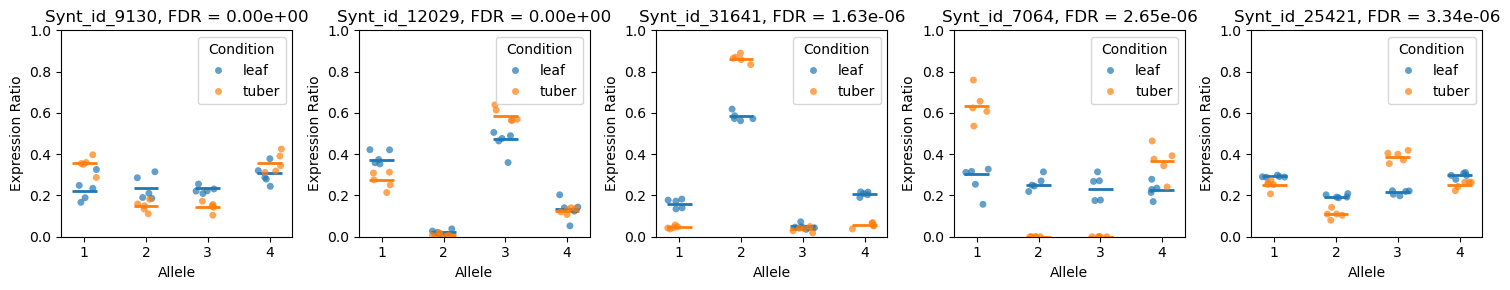

In [22]:
results_trans = test_allelic_ratios_between_conditions(allelic_data_group_filter)


# 3. Plot the results
fig = plot_top_differential_syntelogs(results_trans, figsize=(3*6, 3), sort_by='FDR' )


Lets look again in more detail at one of the genes.

https://spuddb.uga.edu/jb2/?session=share-3b8nGq87AT&password=R8aAc

In [23]:
results_trans[results_trans["Synt_id"] == "Synt_id_31641"]

,Synt_id,allele,transcript_id,p_value,ratio_difference,n_alleles,ratios_leaf_mean,ratios_rep_leaf,ratios_tuber_mean,ratios_rep_tuber,FDR
692,Synt_id_31641,2,Soltu.Atl_v3.12_2G022830.3,4.984393e-09,0.277184,4,0.584637,"[0.5723502304147465, 0.5620689655172414, 0.571...",0.861821,"[0.8341056533827618, 0.8583815028901735, 0.864...",0.000002
691,Synt_id_31641,4,Soltu.Atl_v3.12_4G010920.1,9.283375e-09,0.149927,4,0.206378,"[0.20921658986175115, 0.21724137931034482, 0.2...",0.056451,"[0.0685820203892493, 0.06502890173410404, 0.05...",0.000002
693,Synt_id_31641,1,Soltu.Atl_v3.12_1G007860.2,1.605588e-07,0.114335,4,0.159575,"[0.1824884792626728, 0.1724137931034483, 0.139...",0.045240,"[0.04819277108433735, 0.03757225433526012, 0.0...",0.000014
694,Synt_id_31641,3,Soltu.Atl_v3.12_3G021510.8,2.196968e-01,0.013557,4,0.050078,"[0.035944700460829496, 0.04827586206896552, 0....",0.036521,"[0.04911955514365153, 0.03901734104046243, 0.0...",0.463541


Which allele has the biggest difference between tuber and leaf?

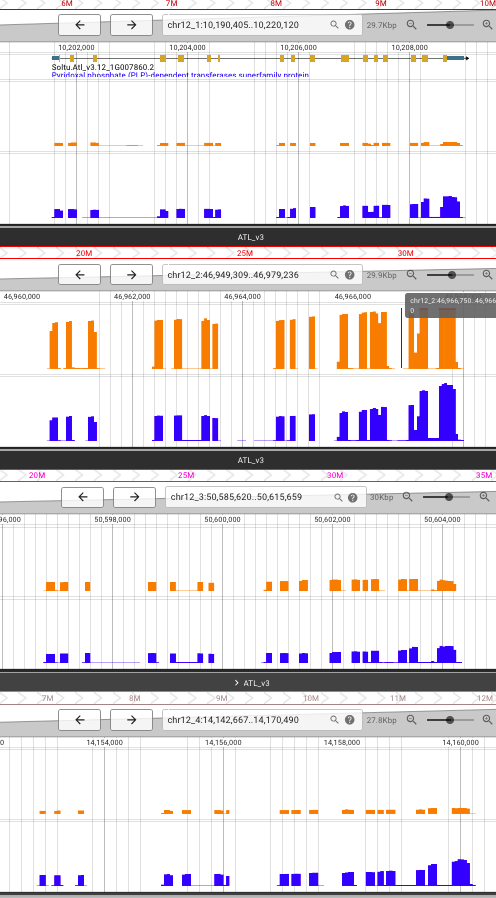

https://spuddb.uga.edu/jb2/?session=local-7vzorxQDd9kfw8i1oFRMz

What the biological mechanisms between the change in allelic expression between conditions? 

Do we have knowledge about tuber specific transcripton facotors that only are present in the promotor of allele 2? 